# GUI Based Labeling of Electrochemical Data

## Gavin Hazen, Jose Lasso, Michael Pence, Sagar Chaudhary

First we import our libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

Next we read our data in as a pandas dataframe. We will delete all the labels upon importing so we can perform human-in-the-loop labeling.

We also import an image of the zone diagram to guide the user in labeling.

In [ ]:
cv_df = pd.read_csv('labels.csv')[['c_cat','c_sub','kc','v','log_gamma','log_lambda','k0','filename','class']]
cv_df['class'] = ''

im = plt.imread('image.png')


Setting up a plotting function

In [36]:
def plot(df, gam, lam, query, title, im):
    plt.figure(figsize=(12,4),dpi=75)
    labelsize = 'xx-large'

    plt.subplot(1,3,1)
    file = cv_df.loc[query, 'filename'].values
    cv = pd.read_csv(file[0])
    plt.plot(cv['potential']-0.55,cv['current']/np.max(cv['current']))
    plt.xlabel(u'Potential (V)',fontsize=labelsize)
    plt.ylabel(u'Normalized Current (au)',fontsize=labelsize)
    plt.title(title)

    plt.subplot(1,3,2)
    plt.imshow(im,extent=[-3,3,-3,4])
    plt.scatter(gam,lam,c='black',marker='x',s=100)
    plt.tight_layout()
    plt.show()

## Initial labeling

Next we randomly choose three points to label as initial training, as our KNN with k value of 3 requires at minimum this many.

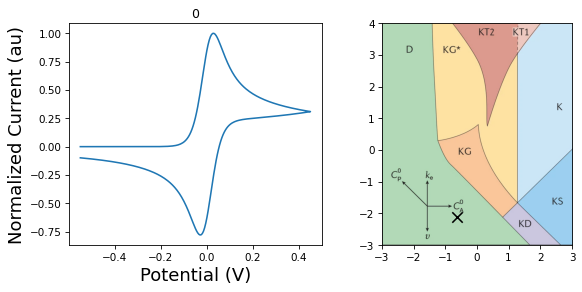

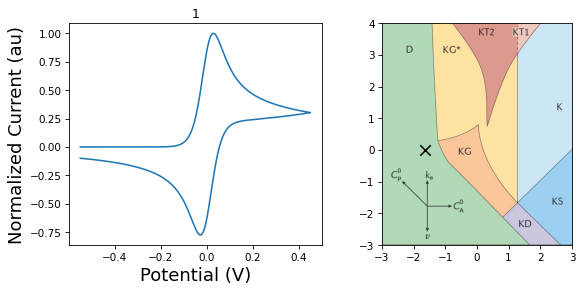

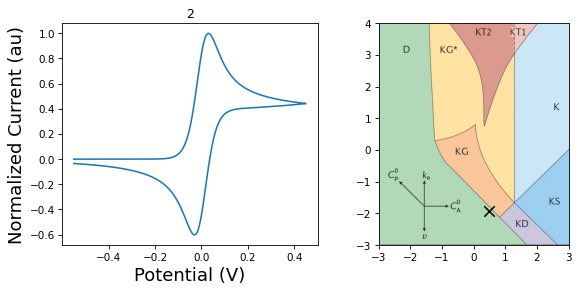

In [49]:
n_init = 3

X_pool = cv_df[['log_gamma','log_lambda']].values
init = np.random.choice(range(X_pool.shape[0]), size=n_init, replace=False)
X_pool = np.delete(X_pool, init, axis=0)

for i, query_idx in enumerate(init):
    
    # this is how we slice into our df based on the query idx    
    gam, lam =  X_pool[query_idx, 0], X_pool[query_idx, 1]
    query = (cv_df['log_gamma'] == gam) & (cv_df['log_lambda'] == lam)

    #plotting the data we want to label
    plot(cv_df, gam, lam, query, i, im)

    #user input is saved into the CSV
    y_query = input()
    cv_df.loc[query, 'class'] = y_query

## Training with initial points

Now we used the input data to setup our active learner which will use uncertainty sampling

In [50]:
labeled = cv_df[cv_df['class'] != '']
X_train = labeled[['log_gamma','log_lambda']].values
y_train = labeled['class'].values

pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=3))])
pipe['knn'].classes_ = ['K','D','KS','KD','KG','KT']

learner = ActiveLearner(
                estimator=pipe,
                X_training=X_train, y_training=y_train,
                query_strategy=uncertainty_sampling
            )

## Active learning

Now we perform active learning by labeling all data

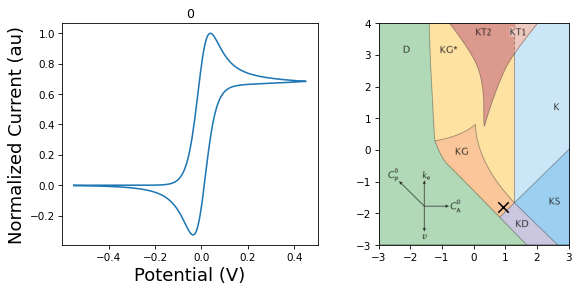

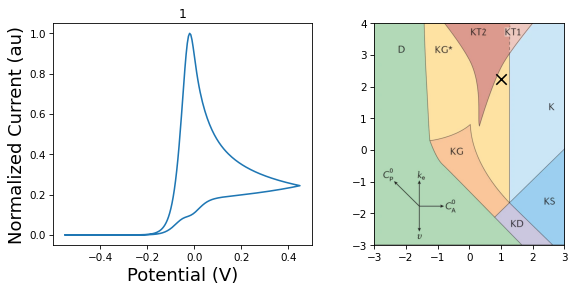

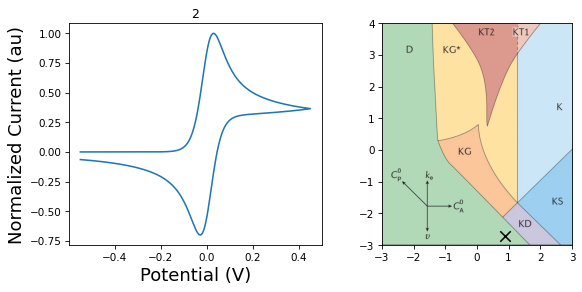

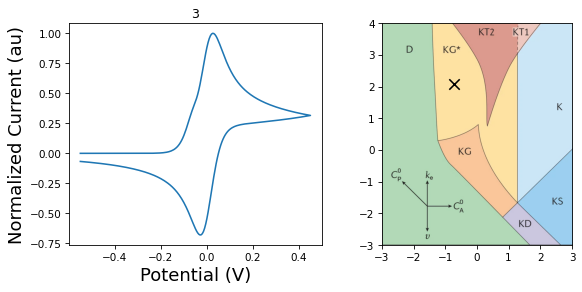

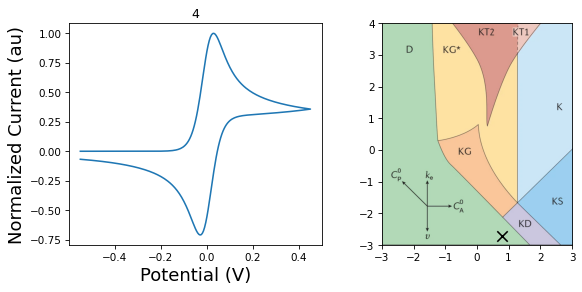

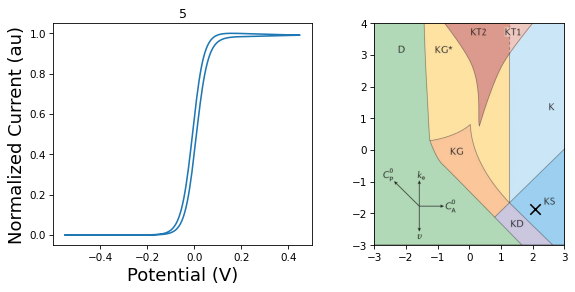

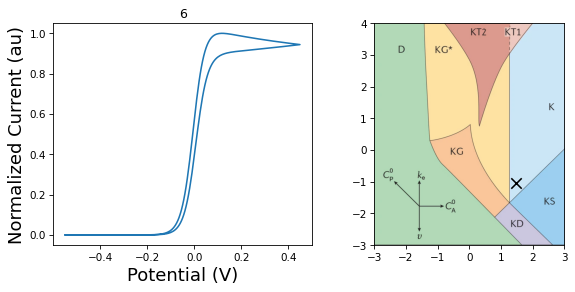

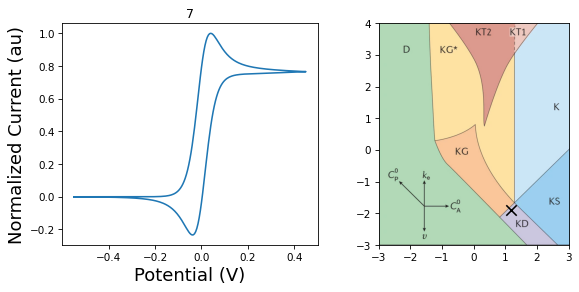

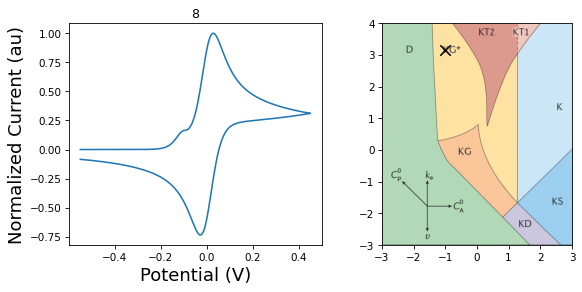

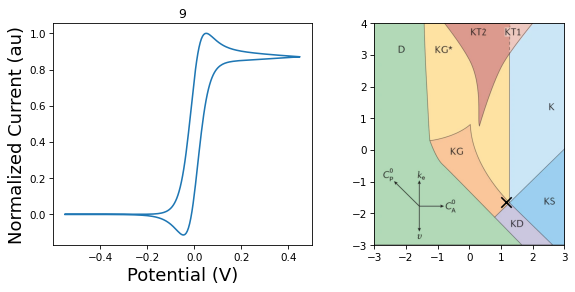

In [51]:
n_queries = 10

for i in range(n_queries):

    query_idx, query_instance = learner.query(X_pool)
    gam, lam = np.squeeze(X_pool[query_idx])[0], np.squeeze(X_pool[query_idx])[1]
    query = (cv_df['log_gamma'] == gam) & (cv_df['log_lambda'] == lam)

    plot(cv_df, gam, lam, query, i, im)
    y_query = input()
    cv_df.loc[query, 'class'] = y_query
    X_pool = np.delete(X_pool, query_idx, axis=0)
    
    learner.teach(
                    X=query_instance,
                    y=[y_query]
                )
    